In [62]:
import pandas as pd
import numpy as np

ACADEMIC_PATH = r'../../data/raw/academic_records.csv'
ADMISSION_PATH = r'../../data/raw/admission.csv'
TEST_PATH = r'../../data/raw/test.csv'
academic_records = pd.read_csv(ACADEMIC_PATH)
admission = pd.read_csv(ADMISSION_PATH)

In [63]:
import pandas as pd
import numpy as np
import re

# --- HÀM MỚI: Xử lý định dạng học kỳ phức tạp ---
def parse_semester_string(sem_str):
    """
    Chuyển đổi chuỗi như 'HK1 2023-2024' thành mã số 20231 để sort được.
    Logic: Năm * 10 + Kỳ
    """
    s = str(sem_str).strip()
    
    # Trường hợp 1: Dạng số sẵn (VD: 20231)
    if s.isdigit():
        return int(s)
    
    # Trường hợp 2: Dạng chữ (VD: HK1 2023-2024 hoặc Học kỳ 1 năm 2023)
    # Tìm tất cả các con số trong chuỗi
    digits = re.findall(r'\d+', s)
    
    if len(digits) >= 2:
        # Giả sử số nhỏ là kỳ, số lớn (4 chữ số) là năm
        # Tìm năm (thường là số có 4 chữ số đầu tiên tìm thấy)
        years = [int(d) for d in digits if len(d) == 4]
        sems = [int(d) for d in digits if len(d) == 1]
        
        if years and sems:
            year = years[0]
            sem = sems[0]
            return year * 10 + sem
            
    return 0 # Không xác định

def clean_data_pipeline_v3(admission, academic_records):
    print("--- 🚀 BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU (FIXED VERSION) ---")
    
    adm = admission.copy()
    acad = academic_records.copy()
    
    # 1. Chuẩn hóa ID
    adm['MA_SO_SV'] = adm['MA_SO_SV'].astype(str)
    acad['MA_SO_SV'] = acad['MA_SO_SV'].astype(str)
    
    # ---------------------------------------------------------
    # [FIX QUAN TRỌNG] Xử lý HOC_KY thông minh hơn
    # ---------------------------------------------------------
    print("-> Đang xử lý cột HOC_KY...")
    # Tạo cột HOC_KY_INT dùng để sort (VD: 20231)
    acad['HOC_KY_INT'] = acad['HOC_KY'].apply(parse_semester_string)
    
    # Kiểm tra xem có dòng nào bị lỗi (bằng 0) không
    error_count = (acad['HOC_KY_INT'] == 0).sum()
    if error_count > 0:
        print(f"   ⚠️ Cảnh báo: Có {error_count} dòng không đọc được HOC_KY.")

    # Merge dữ liệu
    df = pd.merge(acad, adm, on='MA_SO_SV', how='left')
    
    # Sắp xếp theo Time-series chuẩn xác dựa trên cột vừa tạo
    df = df.sort_values(by=['MA_SO_SV', 'HOC_KY_INT']).reset_index(drop=True)
    
    # ---------------------------------------------------------
    # 2. XỬ LÝ SỐ LIỆU & LOGIC
    # ---------------------------------------------------------
    cols_float = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    cols_int = ['TC_DANGKY', 'TC_HOANTHANH']
    
    for col in cols_float:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
    for col in cols_int:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Logic: Hoàn thành <= Đăng ký
    df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
    
    # Target Transformation
    df['COMPLETION_RATE'] = df['TC_HOANTHANH'] / (df['TC_DANGKY'] + 1e-9)
    df['COMPLETION_RATE'] = df['COMPLETION_RATE'].clip(0, 1)

    # Clip điểm số
    df['GPA'] = df['GPA'].clip(0, 4.0)
    df['CPA'] = df['CPA'].clip(0, 4.0)

    # Admission Gap Feature
    if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
        df['ADMISSION_GAP'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
    
    # Lọc rác
    initial_len = len(df)
    df = df[df['TC_DANGKY'] > 0]
    
    print(f"--- ✅ HOÀN TẤT. Kích thước data: {df.shape} ---")
    print("Sample HOC_KY_INT:", df['HOC_KY_INT'].head().tolist())
    
    return df

# Chạy thử lại
df_clean = clean_data_pipeline_v3(admission, academic_records)
df_clean.head()

--- 🚀 BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU (FIXED VERSION) ---
-> Đang xử lý cột HOC_KY...
--- ✅ HOÀN TẤT. Kích thước data: (105726, 14) ---
Sample HOC_KY_INT: [20231, 20232, 20211, 20212, 20221]


,MA_SO_SV,HOC_KY,CPA,GPA,TC_DANGKY,TC_HOANTHANH,HOC_KY_INT,NAM_TUYENSINH,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,COMPLETION_RATE,ADMISSION_GAP
0,00003e092652,HK1 2023-2024,1.64,1.97,18,15,20231,2023,100,A00,21.32,20.25,0.833333,1.07
1,00003e092652,HK2 2023-2024,1.53,2.05,18,13,20232,2023,100,A00,21.32,20.25,0.722222,1.07
2,000e15519006,HK1 2021-2022,3.85,3.85,9,9,20211,2021,1,D07,23.84,22.43,1.000000,1.41
3,000e15519006,HK2 2021-2022,2.77,3.12,19,19,20212,2021,1,D07,23.84,22.43,1.000000,1.41
4,000e15519006,HK1 2022-2023,2.83,2.98,21,21,20221,2021,1,D07,23.84,22.43,1.000000,1.41


In [64]:
import pandas as pd
import numpy as np
import re

# ==============================================================================
# 1. CÁC HÀM TIỆN ÍCH (UTILS)
# ==============================================================================

def parse_semester_string(sem_str):
    """
    Chuyển đổi 'HK1 2023-2024' -> 20231 (Int) để sort time-series.
    """
    s = str(sem_str).strip()
    if s.isdigit(): return int(s)
    
    digits = re.findall(r'\d+', s)
    if len(digits) >= 2:
        years = [int(d) for d in digits if len(d) == 4]
        sems = [int(d) for d in digits if len(d) == 1]
        if years and sems:
            return years[0] * 10 + sems[0]
    return 0

def fast_slope(y):
    """
    Tính hệ số góc (Trend) nhanh.
    Input: Array numpy (có thể chứa NaN).
    """
    # Lọc bỏ NaN trước khi tính (Quan trọng!)
    y_clean = y[~np.isnan(y)]
    n = len(y_clean)
    if n < 2: return 0.0
    
    x = np.arange(n)
    x_mean = np.mean(x)
    y_mean = np.mean(y_clean)
    
    numerator = np.sum((x - x_mean) * (y_clean - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    
    return numerator / (denominator + 1e-6)

# ==============================================================================
# 2. DATA PREPROCESSING PIPELINE
# ==============================================================================

def clean_data_pipeline(admission, academic_records, is_test=False):
    print("--- 🚀 1. PREPROCESSING DATA ---")
    adm = admission.copy()
    acad = academic_records.copy()
    
    # Chuẩn hóa ID
    adm['MA_SO_SV'] = adm['MA_SO_SV'].astype(str)
    acad['MA_SO_SV'] = acad['MA_SO_SV'].astype(str)
    
    # Tạo Time-Index
    acad['semester_order'] = acad['HOC_KY'].apply(parse_semester_string)
    
    # Merge
    df = pd.merge(acad, adm, on='MA_SO_SV', how='left')
    
    # Sort Time-Series (CỰC KỲ QUAN TRỌNG)
    df = df.sort_values(by=['MA_SO_SV', 'semester_order']).reset_index(drop=True)
    
    # Numeric conversion
    cols_float = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    cols_int = ['TC_DANGKY', 'TC_HOANTHANH']
    
    for col in cols_float:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    for col in cols_int:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Logic clean
    if not is_test:
        df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
        df['GPA'] = df['GPA'].clip(0, 4.0)
        df['CPA'] = df['CPA'].clip(0, 4.0)
    
    # Target Transformation (Chỉ dùng cho train)
    if not is_test:
        df['COMPLETION_RATE'] = df['TC_HOANTHANH'] / (df['TC_DANGKY'] + 1e-9)
        df['COMPLETION_RATE'] = df['COMPLETION_RATE'].clip(0, 1)

    return df

# ==============================================================================
# 3. FEATURE ENGINEERING CLASS (CORE)
# ==============================================================================

class FeatureEngineer:    
    def __init__(self):
        # Các cột Category sẽ giữ lại
        self.cat_cols = ['PTXT', 'TOHOP_XT', 'MA_NGANH', 'KV_UT', 'KHOA_VIEN'] 

    def create_features(self, df):
        print("--- ⚡ 2. FEATURE ENGINEERING (FULL POWER) ---")
        df = df.copy()
        
        # Sort lại cho chắc chắn
        df = df.sort_values(['MA_SO_SV', 'semester_order']).reset_index(drop=True)
        
        # Convert Category
        for col in self.cat_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).astype('category')

        # Groupby object
        g = df.groupby('MA_SO_SV')

        # ---------------------------------------------------------
        # A. BASE LAGS (Cực kỳ quan trọng: Dùng shift(1) để tránh Leakage)
        # ---------------------------------------------------------
        # Tạo biến Raw (chứa NaN) để tính toán thống kê chính xác hơn
        df['Prev_GPA_Raw'] = g['GPA'].shift(1)
        
        # Tạo biến Fill (để model dùng trực tiếp)
        df['Prev_GPA'] = df['Prev_GPA_Raw'].fillna(-1)
        df['Prev_CPA'] = g['CPA'].shift(1).fillna(-1)
        df['Prev_TC_HOANTHANH'] = g['TC_HOANTHANH'].shift(1).fillna(0)
        df['Prev_TC_DANGKY'] = g['TC_DANGKY'].shift(1).fillna(0)
        
        # Cờ năm nhất (Chưa có lịch sử)
        df['is_freshman'] = (df['Prev_TC_DANGKY'] == 0).astype(int)

        # ---------------------------------------------------------
        # B. GỌI CÁC NHÓM FEATURE
        # ---------------------------------------------------------
        df = self._create_admission_features(df)
        df = self._create_history_features(df)
        df = self._create_trend_features(df)  # <--- Slope, Volatility nằm ở đây
        df = self._create_risk_features(df)
        
        # Dọn dẹp cột tạm
        if 'Prev_GPA_Raw' in df.columns:
            df = df.drop(columns=['Prev_GPA_Raw'])
            
        return df

    def _create_admission_features(self, df):
        # Khoảng cách điểm đầu vào
        if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
            df['diem_vuot_chuan'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
        
        # Tuổi (giả định năm hiện tại 2025/2026)
        if 'NAM_TUYENSINH' in df.columns:
            df['nam_tuoi'] = 2026 - df['NAM_TUYENSINH']
            
        # Số kỳ đã học (tính từ năm nhập học)
        df['semester_number'] = df.groupby('MA_SO_SV').cumcount() + 1
        return df

    def _create_history_features(self, df):
        # 1. Delta GPA-CPA: Đang học tốt hơn hay tệ hơn trung bình tích lũy?
        df['prev_gpa_cpa_diff'] = df['Prev_GPA'] - df['Prev_CPA']
        
        # 2. Tỷ lệ hoàn thành kỳ trước
        df['prev_completion_rate'] = df['Prev_TC_HOANTHANH'] / (df['Prev_TC_DANGKY'] + 1e-9)
        
        # 3. Load Factor (Áp lực): Đăng ký kỳ này / Sức học trung bình
        avg_capacity = df.groupby('MA_SO_SV')['Prev_TC_HOANTHANH'].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        ).fillna(15)
        
        df['load_factor'] = df['TC_DANGKY'] / (avg_capacity + 1e-9)
        
        # Biến cờ: Rớt môn kỳ trước
        df['failed_last_sem'] = (df['Prev_TC_HOANTHANH'] < df['Prev_TC_DANGKY']).astype(int)
        
        return df

    def _create_trend_features(self, df):
        # Sử dụng Prev_GPA_Raw (có NaN) để tính Slope chính xác
        # Nếu dùng Prev_GPA (có -1), Slope sẽ bị sai lệch lớn
        g_raw = df.groupby('MA_SO_SV')['Prev_GPA_Raw']
        
        # 1. GPA Slope (Xu hướng điểm)
        df['gpa_trend_slope'] = g_raw.transform(
            lambda x: x.rolling(window=3, min_periods=2).apply(fast_slope, raw=True)
        ).fillna(0)
        
        # 2. [RECOVERED] GPA Volatility (Độ ổn định)
        df['gpa_volatility'] = g_raw.transform(
            lambda x: x.rolling(window=4, min_periods=2).std()
        ).fillna(0)
        
        # 3. Tích lũy tín chỉ (History)
        grouped = df.groupby('MA_SO_SV')
        cum_dangky = grouped['Prev_TC_DANGKY'].cumsum()
        cum_hoanthanh = grouped['Prev_TC_HOANTHANH'].cumsum()
        
        df['total_credits_failed'] = cum_dangky - cum_hoanthanh
        df['accumulated_fail_ratio'] = df['total_credits_failed'] / (cum_dangky + 1e-9)
        
        # 4. [RECOVERED] Credit Velocity (Tốc độ học)
        semester_count = grouped.cumcount() + 1
        df['credit_velocity'] = cum_hoanthanh / semester_count
        
        return df

    def _create_risk_features(self, df):
        # Hành vi "Gỡ gạc" (Aggressive Recovery): Rớt môn kỳ trước -> Đăng ký nhiều hơn kỳ này
        more_credits = (df['TC_DANGKY'] > df['Prev_TC_DANGKY'])
        df['aggressive_recovery'] = (df['failed_last_sem'] & more_credits).astype(int)
        
        # Kỳ vọng hoàn thành (Expected Credits) = Đăng ký * Tỷ lệ đậu toàn cục của SV đó
        df['expected_real_credits'] = df['TC_DANGKY'] * (1 - df['accumulated_fail_ratio'])
        
        return df

    def get_feature_columns(self, df):
        """Tự động lấy danh sách feature dựa trên prefix"""
        
        # Whitelist các prefix
        valid_prefixes = [
            'Prev_', 'prev_', 'sem_', 'diem_', 'nam_', 'is_', 
            'load_', 'aggressive_', 'gpa_', 'total_', 'accumulated_',
            'credit_', 'expected_', 'failed_'
        ]
        
        valid_exact = ['TC_DANGKY', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'semester_number']
        valid_exact.extend(self.cat_cols)
        
        final_cols = []
        # Các cột target/meta cần loại bỏ
        ignore_cols = ['TC_HOANTHANH', 'GPA', 'CPA', 'semester_order', 'MA_SO_SV', 'HOC_KY', 'COMPLETION_RATE', 'Prev_GPA_Raw']
        
        for col in df.columns:
            if col in ignore_cols: continue
            
            is_valid = False
            if col in valid_exact: is_valid = True
            else:
                for prefix in valid_prefixes:
                    if col.startswith(prefix):
                        is_valid = True
                        break
            
            if is_valid: final_cols.append(col)
                
        return final_cols

# ==============================================================================
# 4. EXECUTION BLOCK (CHẠY THỬ)
# ==============================================================================


test_raw = pd.read_csv(TEST_PATH)

print("--- BẮT ĐẦU PIPELINE ---")

# 1. Clean Data
df_train_raw = clean_data_pipeline(admission, academic_records, is_test=False)

# 2. Chuẩn bị Test (Gán dummy values để chạy được pipeline)
test_copy = test_raw.copy()
for col in ['TC_HOANTHANH', 'GPA', 'CPA']: test_copy[col] = 0
df_test_raw = clean_data_pipeline(admission, test_copy, is_test=True)

# 3. Gộp Train + Test để tạo feature (Tránh biên giới giữa các kỳ bị đứt gãy)
df_train_raw['set_type'] = 'TRAIN'
df_test_raw['set_type'] = 'TEST'
full_df = pd.concat([df_train_raw, df_test_raw], ignore_index=True)

# 4. Feature Engineering
fe = FeatureEngineer()
full_df_fe = fe.create_features(full_df)

# 5. Tách lại Train/Test
train_final = full_df_fe[full_df_fe['set_type'] == 'TRAIN'].copy()
test_final = full_df_fe[full_df_fe['set_type'] == 'TEST'].copy()

# 6. Lấy features & Target
feature_cols = fe.get_feature_columns(train_final)
X = train_final[feature_cols]
y = train_final['TC_HOANTHANH'] # Hoặc dùng COMPLETION_RATE nếu muốn

print(f"✅ Xong! Số lượng Features: {len(feature_cols)}")
print(f"Sample Features: {feature_cols[:5]}")

--- BẮT ĐẦU PIPELINE ---
--- 🚀 1. PREPROCESSING DATA ---
--- 🚀 1. PREPROCESSING DATA ---
--- ⚡ 2. FEATURE ENGINEERING (FULL POWER) ---
✅ Xong! Số lượng Features: 24
Sample Features: ['TC_DANGKY', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']


--- 🚀 3. TRAINING PHASE (XGBOOST) ---
Đang convert category sang số...
Kích thước tập Train: (90582, 24)
Kích thước tập Valid: (15144, 24)

Đang train model... (Vui lòng đợi)
[0]	validation_0-rmse:0.25365	validation_1-rmse:0.28332
[200]	validation_0-rmse:0.18931	validation_1-rmse:0.21322
[319]	validation_0-rmse:0.18604	validation_1-rmse:0.21337

>>> RMSE trên tập Valid (HK2 2023-2024): 3.7665
Note: RMSE càng thấp càng tốt. Nếu < 2.0 là khá ổn.

--- 4. PREDICTING TEST SET (HK1 2024-2025) ---
✅ Đã lưu file kết quả: submission_xgboost_v2.csv
        MA_SO_SV  PRED_TC_HOANTHANH
2   00003e092652          15.206262
3   00027b0dec4c          17.491538
10  000e15519006          17.668126
13  000ea6e12003          16.334039
16  00109b845a3d           5.353341


<Figure size 1000x800 with 0 Axes>

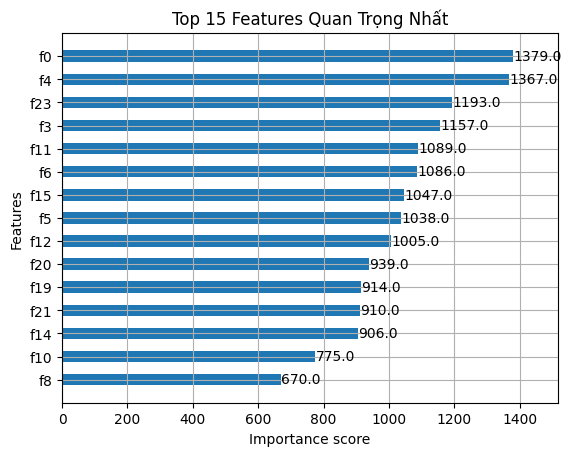

In [66]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

print("--- 🚀 3. TRAINING PHASE (XGBOOST) ---")

# ==============================================================================
# 1. CHUẨN BỊ DỮ LIỆU (SPLIT TRAIN/VALID)
# ==============================================================================
# Định nghĩa mốc thời gian theo đề bài
SPLIT_SEM = 20231  # Train đến hết HK1 2023-2024
VALID_SEM = 20232  # Valid là HK2 2023-2024

# Lọc dữ liệu từ full_df_fe (kết quả của bước Feature Engineering trước)
# Lưu ý: Loại bỏ các dòng Test ra khỏi quá trình train
df_modeling = full_df_fe[full_df_fe['set_type'] == 'TRAIN'].copy()

cat_cols = ['PTXT', 'TOHOP_XT']
print("Đang convert category sang số...")

for col in cat_cols:
    if col in df_modeling.columns:
        # Chuyển về string -> category -> mã số (int)
        df_modeling[col] = df_modeling[col].astype(str).astype('category').cat.codes

# Chia Train/Valid
train_mask = df_modeling['semester_order'] <= SPLIT_SEM
valid_mask = df_modeling['semester_order'] == VALID_SEM

X_train = df_modeling[train_mask][feature_cols]
y_train = df_modeling[train_mask]['COMPLETION_RATE'] # Train trên Rate
w_train = df_modeling[train_mask]['TC_DANGKY']       # (Optional) Trọng số: Môn nhiều tín quan trọng hơn

X_valid = df_modeling[valid_mask][feature_cols]
y_valid_rate = df_modeling[valid_mask]['COMPLETION_RATE']
y_valid_credits = df_modeling[valid_mask]['TC_HOANTHANH'] # Target thật (số tín) để đo RMSE
valid_credits_dangky = df_modeling[valid_mask]['TC_DANGKY'] # Dùng để convert Rate -> Credits

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Valid: {X_valid.shape}")

# ==============================================================================
# 2. CẤU HÌNH & TRAIN MODEL
# ==============================================================================
# XGBoost Parameters - Đã được tối ưu sơ bộ cho bài toán Regression
# ==============================================================================
# 2. CẤU HÌNH & TRAIN MODEL (ĐÃ SỬA LỖI)
# ==============================================================================
params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 100,
    
    # --- QUAN TRỌNG: PHẢI BẬT 2 DÒNG NÀY ---
    #'enable_categorical': True,  # Cho phép xử lý cột category (PTXT, TOHOP_XT...)
    'tree_method': 'hist',       # Bắt buộc dùng 'hist' (hoặc 'gpu_hist') để hỗ trợ category tốt nhất
    # ---------------------------------------
}

model = xgb.XGBRegressor(**params)

print("\nĐang train model... (Vui lòng đợi)")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid_rate)],
    verbose=200
)

# ==============================================================================
# 3. ĐÁNH GIÁ TRÊN TẬP VALID (QUAN TRỌNG)
# ==============================================================================
# Dự báo Rate
pred_rate_valid = model.predict(X_valid)

# HẬU XỬ LÝ (Post-Processing Strategy)
# 1. Clip Rate về [0, 1]
pred_rate_valid = np.clip(pred_rate_valid, 0, 1)

# 2. Convert về Số tín chỉ: Rate * TC_DANGKY
pred_credits_valid = pred_rate_valid * valid_credits_dangky

# 3. Hard Limit: Không bao giờ được vượt quá đăng ký (Dù model có sai số)
pred_credits_valid = np.minimum(pred_credits_valid, valid_credits_dangky)

# 4. Tính RMSE (Đơn vị: Tín chỉ)
rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits_valid))
print(f"\n>>> RMSE trên tập Valid (HK2 2023-2024): {rmse:.4f}")
print("Note: RMSE càng thấp càng tốt. Nếu < 2.0 là khá ổn.")

# ==============================================================================
# 4. DỰ BÁO TẬP TEST & TẠO FILE NỘP
# ==============================================================================
print("\n--- 4. PREDICTING TEST SET (HK1 2024-2025) ---")
test_final = full_df_fe[full_df_fe['set_type'] == 'TEST'].copy()
X_test = test_final[feature_cols]
test_dangky = test_final['TC_DANGKY']

for col in cat_cols:
    if col in X_test.columns:
        # Chuyển về string -> category -> mã số (int)
        X_test[col] = X_test[col].astype(str).astype('category').cat.codes

# Dự báo
pred_rate_test = model.predict(X_test)

# Hậu xử lý tương tự
pred_rate_test = np.clip(pred_rate_test, 0, 1)
pred_credits_test = pred_rate_test * test_dangky
pred_credits_test = np.minimum(pred_credits_test, test_dangky)

# Yêu cầu đề bài: Kết quả là số nguyên (Int) 
# Nhưng để an toàn cho RMSE, ta có thể round closest (làm tròn chuẩn)
final_submission = pred_credits_test

# Tạo DataFrame nộp bài
submission_df = pd.DataFrame({
    'MA_SO_SV': test_final['MA_SO_SV'],
    'PRED_TC_HOANTHANH': final_submission
})

# Lưu file
output_filename = 'submission_xgboost_v2.csv'
submission_df.to_csv(output_filename, index=False)
print(f"✅ Đã lưu file kết quả: {output_filename}")
print(submission_df.head())

# ==============================================================================
# 5. FEATURE IMPORTANCE (GIẢI THÍCH MODEL)
# ==============================================================================
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Features Quan Trọng Nhất")
plt.show()

In [61]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

print("--- 🔍 STARTING OPTUNA FOR XGBOOST (FIXED VERSION) ---")

def objective(trial):
    # 1. Định nghĩa không gian tham số
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        # Các tham số cố định
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'enable_categorical': True,
        'tree_method': 'hist',
        # Lưu ý: Nếu phiên bản XGB cũ, early_stopping_rounds có thể cần đưa vào fit() thay vì ở đây
        # Nhưng để an toàn, ta cứ để ở constructor, nếu nó warning thì kệ nó
        'early_stopping_rounds': 100 
    }
    
    # 2. Khởi tạo model
    model = xgb.XGBRegressor(**params)
    
    # 3. Train model (ĐÃ BỎ CALLBACKS ĐỂ TRÁNH LỖI)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid_rate)],
        verbose=False
    )
    

    # 2. Convert về Số tín chỉ: Rate * TC_DANGKY
    pred_credits_valid = pred_rate_valid * valid_credits_dangky

    # 3. Hard Limit: Không bao giờ được vượt quá đăng ký (Dù model có sai số)
    pred_credits_valid = np.minimum(pred_credits_valid, valid_credits_dangky)

    # 4. Tính RMSE (Đơn vị: Tín chỉ)
    rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits_valid))
    return rmse

# Chạy Optuna (Tắt progress bar nếu muốn log gọn hơn)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) 

print("\n--- ✅ OPTUNA FINISHED ---")
print(f"Best RMSE: {study.best_value:.4f}")
print("Best Params:", study.best_params)

# --- CẬP NHẬT LẠI MODEL VỚI THAM SỐ TỐT NHẤT ---
best_xgb_params = study.best_params
best_xgb_params.update({
    'n_estimators': 2000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'enable_categorical': True,
    'tree_method': 'hist',
    'early_stopping_rounds': 100
})

model_xgb = xgb.XGBRegressor(**best_xgb_params)
print("-> Đã cập nhật model_xgb với tham số tối ưu từ Optuna!")

[I 2026-02-03 22:54:56,106] A new study created in memory with name: no-name-03a30e80-67b9-44f9-8444-3250753dab35


--- 🔍 STARTING OPTUNA FOR XGBOOST (FIXED VERSION) ---


[I 2026-02-03 22:54:58,402] Trial 0 finished with value: 3.771451605902984 and parameters: {'learning_rate': 0.02225834847613203, 'max_depth': 3, 'subsample': 0.7890282826073614, 'colsample_bytree': 0.6642794326342307, 'reg_alpha': 1.0394795025781856, 'reg_lambda': 9.049598282641512, 'min_child_weight': 1}. Best is trial 0 with value: 3.771451605902984.
[I 2026-02-03 22:55:04,218] Trial 1 finished with value: 3.771451605902984 and parameters: {'learning_rate': 0.005240594989673374, 'max_depth': 6, 'subsample': 0.6326550154741167, 'colsample_bytree': 0.9301702211942159, 'reg_alpha': 5.1536392966475635, 'reg_lambda': 6.292484159804558, 'min_child_weight': 2}. Best is trial 0 with value: 3.771451605902984.
[I 2026-02-03 22:55:05,664] Trial 2 finished with value: 3.771451605902984 and parameters: {'learning_rate': 0.04530086173221803, 'max_depth': 10, 'subsample': 0.6848965007138126, 'colsample_bytree': 0.9115094519522612, 'reg_alpha': 6.7884564764989355, 'reg_lambda': 4.916576339321836, '

KeyboardInterrupt: 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11292\766821697.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp.head(20), palette='viridis')


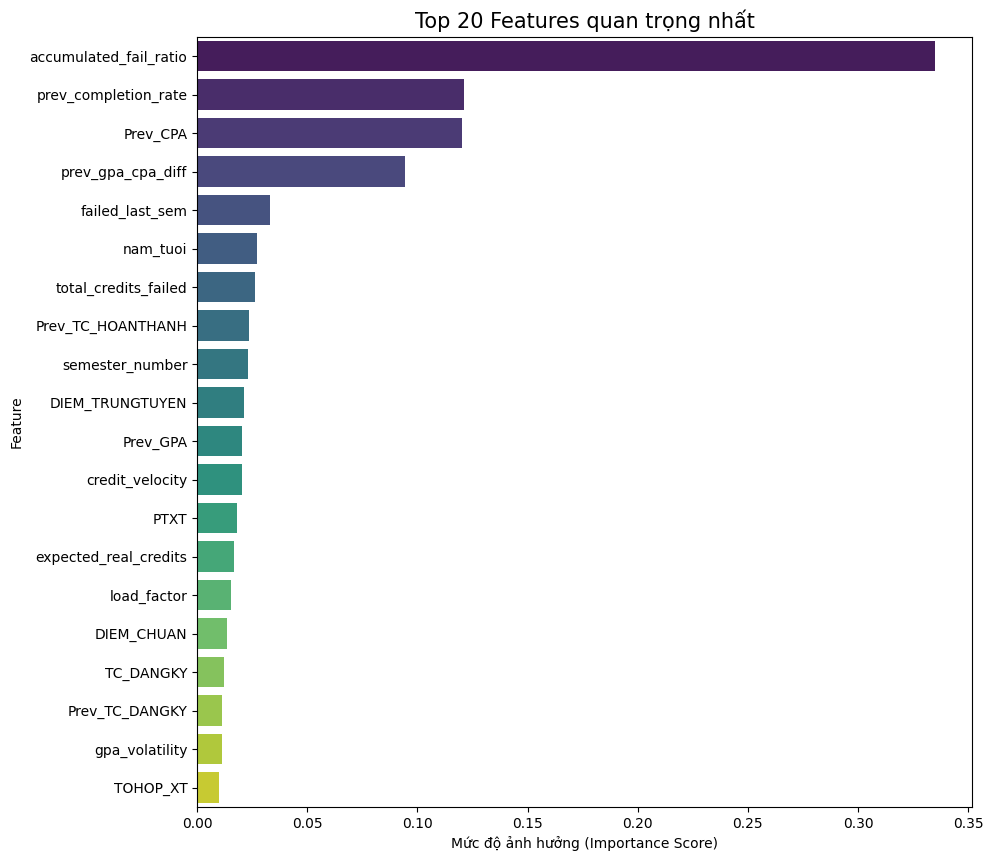

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Giả sử 'model' là model bạn đã train (XGBoost, RandomForest...)
# Giả sử 'X' là dataframe chứa các features

def plot_simple_importance(model, feature_names):
    # Lấy giá trị importance
    if hasattr(model, 'feature_importances_'):
        vals = model.feature_importances_
    elif hasattr(model, 'get_score'): # Dành cho XGBoost native API
        vals = list(model.get_score(importance_type='gain').values())
    else:
        print("Model không hỗ trợ lấy feature_importances_ trực tiếp")
        return

    # Tạo DataFrame
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': vals
    }).sort_values('Importance', ascending=False)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 10))
    sns.barplot(x='Importance', y='Feature', data=df_imp.head(20), palette='viridis')
    plt.title('Top 20 Features quan trọng nhất', fontsize=15)
    plt.xlabel('Mức độ ảnh hưởng (Importance Score)')
    plt.show()

# GỌI HÀM
plot_simple_importance(model, X.columns)